In [6]:
#Importing necessary libraries
import numpy as np
import pandas as pd

import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt


In [7]:
# Configuration
CSV_PATH = r"C:\Users\user\Documents\Deep Learning\PV Forecasting Project\DATASET GHI,T,PVout.csv"
SEP = ";"
ENCODING = "utf-8-sig"

# Kolom
TIME_COL = "time"
FEATURE_COLS = ["ambient_temperature", "ground_level_solar_irradiance"]
TARGET_COL = "pvout"

# Time-series split
TRAIN_RATIO = 0.70
VAL_RATIO   = 0.10
TEST_RATIO  = 0.20

# Window
LOOKBACK = 24  # 168 jam = 1 minggu (kalau hourly)

# Model architecture
RNN_LAYERS = 2     # jumlah hidden layer RNN (SimpleRNN bertumpuk)
RNN_UNITS  = 64    # unit per layer
DROPOUT    = 0.1   # 0.0 untuk off

# Optional Dense hidden sebelum output (0 = off)
DENSE_HIDDEN_UNITS = 0  # contoh: 32 kalau mau aktif

# ===== Training =====
EPOCHS = 50
BATCH_SIZE = 32
PATIENCE = 5

# ===== Cross-validation (opsional) =====
RUN_CV = True
N_SPLITS = 10

# ===== Reproducibility =====
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("Config OK")


Config OK


In [8]:
# Load data
df = pd.read_csv(CSV_PATH, sep=SEP, encoding=ENCODING)

df.columns = (
    df.columns
    .str.strip()
    .str.lower()
    .str.replace(" ", "_")
)

print("Shape:", df.shape)
print("Columns:", list(df.columns))
df.head()


Shape: (8784, 4)
Columns: ['time', 'ambient_temperature', 'ground_level_solar_irradiance', 'pvout']


,time,ambient_temperature,ground_level_solar_irradiance,pvout
0,01/01/2024 00:00,30.336,481.830,149809.518
1,01/01/2024 01:00,30.970,652.110,198922.392
2,01/01/2024 02:00,31.430,770.406,230647.718
3,01/01/2024 03:00,31.803,827.435,245019.371
4,01/01/2024 04:00,32.056,842.527,248055.079


In [9]:
# Validasi Kolom
need_cols = [TIME_COL] + FEATURE_COLS + [TARGET_COL]
missing = [c for c in need_cols if c not in df.columns]
if missing:
    raise ValueError(f"Kolom tidak ditemukan: {missing}\nKolom tersedia: {list(df.columns)}")

df[TIME_COL] = pd.to_datetime(df[TIME_COL], dayfirst=True, errors="coerce")
df = df.dropna(subset=[TIME_COL]).sort_values(TIME_COL).reset_index(drop=True)

print("After time parse+sort:", df.shape)
df[[TIME_COL] + FEATURE_COLS + [TARGET_COL]].head()



After time parse+sort: (8784, 4)


,time,ambient_temperature,ground_level_solar_irradiance,pvout
0,2024-01-01 00:00:00,30.336,481.830,149809.518
1,2024-01-01 01:00:00,30.970,652.110,198922.392
2,2024-01-01 02:00:00,31.430,770.406,230647.718
3,2024-01-01 03:00:00,31.803,827.435,245019.371
4,2024-01-01 04:00:00,32.056,842.527,248055.079


In [10]:
# Features dan Target
FEATURE_COLS = [
    "ambient_temperature",
    "ground_level_solar_irradiance"
]

TARGET_COL = "pvout"

In [11]:
# Hitung jumlah baris
n_rows = len(df)
if n_rows <= LOOKBACK:
    raise ValueError(f"Data terlalu sedikit: len(df)={n_rows} harus > LOOKBACK={LOOKBACK}")

n_seq = n_rows - LOOKBACK  # jumlah sample sequence

train_n = int(TRAIN_RATIO * n_seq)
val_n   = int(VAL_RATIO * n_seq)
test_n  = n_seq - train_n - val_n

assert train_n > 0 and val_n > 0 and test_n > 0, "Split menghasilkan 0 sample, cek data/LOOKBACK/ratio"

print("Total rows:", n_rows)
print("Total sequences:", n_seq)
print(f"Train/Val/Test sequences: {train_n}/{val_n}/{test_n}")

Total rows: 8784
Total sequences: 8760
Train/Val/Test sequences: 6132/876/1752


In [12]:
# Scaling tanpa leakage
train_fit_rows = LOOKBACK + train_n

X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X_scaler.fit(df.iloc[:train_fit_rows][FEATURE_COLS])
y_scaler.fit(df.iloc[:train_fit_rows][[TARGET_COL]])

X_scaled = X_scaler.transform(df[FEATURE_COLS]).astype(np.float32)
y_scaled = y_scaler.transform(df[[TARGET_COL]]).astype(np.float32).flatten()

print("X_scaled:", X_scaled.shape, "y_scaled:", y_scaled.shape)



X_scaled: (8784, 2) y_scaled: (8784,)


In [13]:
# Buat Sequence
def create_sequences(X, y, lookback: int):
    Xs, ys = [], []
    for i in range(lookback, len(X)):
        Xs.append(X[i - lookback:i])
        ys.append(y[i])
    return np.array(Xs, dtype=np.float32), np.array(ys, dtype=np.float32)

X_seq, y_seq = create_sequences(X_scaled, y_scaled, LOOKBACK)

time_seq = df[TIME_COL].iloc[LOOKBACK:].reset_index(drop=True)

print("X_seq:", X_seq.shape, "y_seq:", y_seq.shape, "time_seq:", time_seq.shape)


X_seq: (8760, 24, 2) y_seq: (8760,) time_seq: (8760,)


In [14]:
# Split Train/Val/Test
train_end = train_n
val_end   = train_n + val_n

X_train, y_train = X_seq[:train_end], y_seq[:train_end]
X_val,   y_val   = X_seq[train_end:val_end], y_seq[train_end:val_end]
X_test,  y_test  = X_seq[val_end:], y_seq[val_end:]

time_test = time_seq.iloc[val_end:].reset_index(drop=True)

print("Shapes:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val  :", X_val.shape,   "y_val  :", y_val.shape)
print("X_test :", X_test.shape,  "y_test :", y_test.shape)



Shapes:
X_train: (6132, 24, 2) y_train: (6132,)
X_val  : (876, 24, 2) y_val  : (876,)
X_test : (1752, 24, 2) y_test : (1752,)


In [15]:
# Build Model
def build_model(input_shape, rnn_layers=1, rnn_units=64, dropout=0.0, dense_hidden_units=0):
    model = Sequential()

    for i in range(rnn_layers):
        return_seq = (i < rnn_layers - 1)

        if i == 0:
            model.add(SimpleRNN(rnn_units, activation="tanh",
                                return_sequences=return_seq,
                                input_shape=input_shape))
        else:
            model.add(SimpleRNN(rnn_units, activation="tanh",
                                return_sequences=return_seq))

        if dropout and dropout > 0:
            model.add(Dropout(dropout))

    if dense_hidden_units and dense_hidden_units > 0:
        model.add(Dense(dense_hidden_units, activation="relu"))

    model.add(Dense(1))
    model.compile(optimizer="adam", loss="mse")
    return model

model = build_model(
    input_shape=(LOOKBACK, len(FEATURE_COLS)),
    rnn_layers=RNN_LAYERS,
    rnn_units=RNN_UNITS,
    dropout=DROPOUT,
    dense_hidden_units=DENSE_HIDDEN_UNITS
)

model.summary()


c:\Users\user\anaconda3\envs\dl310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 24, 64)         │         4,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,609 (49.25 KB)

 Trainable params: 12,609 (49.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Cross-Validation
if RUN_CV:
    n_trainval = train_n + val_n
    tscv = TimeSeriesSplit(n_splits=N_SPLITS)

    fold_rows = []
    for fold, (tr_idx, va_idx) in enumerate(tscv.split(np.arange(n_trainval)), start=1):
        fold_train_end = tr_idx[-1] + 1
        fold_val_end   = va_idx[-1] + 1

        # Fit scaler hanya pada training fold (plus LOOKBACK context)
        fit_rows = LOOKBACK + fold_train_end

        X_scaled_f = X_scaler_f.transform(df.iloc[:end_row][FEATURE_COLS]).astype(np.float32)
        y_scaled_f = y_scaler_f.transform(df.iloc[:end_row][[TARGET_COL]]).astype(np.float32).flatten()


        X_scaled_f = X_scaler_f.transform(df[FEATURE_COLS]).astype(np.float32)
        y_scaled_f = y_scaler_f.transform(df[[TARGET_COL]]).astype(np.float32).flatten()

        # Build sequences sampai fold_val_end saja
        end_row = LOOKBACK + fold_val_end
        Xs, ys = [], []
        for i in range(LOOKBACK, end_row):
            Xs.append(X_scaled_f[i - LOOKBACK:i])
            ys.append(y_scaled_f[i])

        X_seq_f = np.array(Xs, dtype=np.float32)
        y_seq_f = np.array(ys, dtype=np.float32)

        X_tr, y_tr = X_seq_f[:fold_train_end], y_seq_f[:fold_train_end]
        X_va, y_va = X_seq_f[fold_train_end:fold_val_end], y_seq_f[fold_train_end:fold_val_end]

        m = build_model(
            input_shape=(LOOKBACK, len(FEATURE_COLS)),
            rnn_layers=RNN_LAYERS,
            rnn_units=RNN_UNITS,
            dropout=DROPOUT,
            dense_hidden_units=DENSE_HIDDEN_UNITS
        )

        es = EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights=True)

        m.fit(
            X_tr, y_tr,
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            validation_data=(X_va, y_va),
            shuffle=False,
            callbacks=[es],
            verbose=0
        )

        y_va_pred = m.predict(X_va, verbose=0).flatten()

        # CLIP prediksi di domain MinMax
        y_va_pred = np.clip(y_va_pred, 0.0, 1.0)

        y_va_inv = y_scaler_f.inverse_transform(y_va.reshape(-1, 1)).flatten()
        y_va_pred_inv = y_scaler_f.inverse_transform(y_va_pred.reshape(-1, 1)).flatten()

        # Safety clip skala asli
        y_va_pred_inv = np.clip(y_va_pred_inv, 0.0, None)


        rmse = float(np.sqrt(mean_squared_error(y_va_inv, y_va_pred_inv)))
        r2   = float(r2_score(y_va_inv, y_va_pred_inv))

        fold_rows.append({"fold": fold, "rmse": rmse, "r2": r2})
        print(f"Fold {fold:02d}: RMSE={rmse:.4f}, R2={r2:.4f}")

    df_cv = pd.DataFrame(fold_rows)
    print("\n=== CV Summary ===")
    display(df_cv)
    print(df_cv[["rmse", "r2"]].agg(["mean", "std"]))
else:
    print("RUN_CV=False -> skip CV")


In [ ]:
# Train Final Model
model = build_model(
    input_shape=(LOOKBACK, len(FEATURE_COLS)),
    rnn_layers=RNN_LAYERS,
    rnn_units=RNN_UNITS,
    dropout=DROPOUT,
    dense_hidden_units=DENSE_HIDDEN_UNITS
)

es = EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    shuffle=False,
    callbacks=[es],
    verbose=1
)



Epoch 1/50


c:\Users\user\anaconda3\envs\dl310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


189/189 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - loss: 0.0336 - val_loss: 0.0014
Epoch 2/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 0.0079 - val_loss: 0.0011
Epoch 3/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 0.0045 - val_loss: 0.0016
Epoch 4/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 0.0032 - val_loss: 7.2170e-04
Epoch 5/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 0.0027 - val_loss: 6.2642e-04
Epoch 6/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - loss: 0.0024 - val_loss: 7.4835e-04
Epoch 7/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - loss: 0.0020 - val_loss: 6.4935e-04
Epoch 8/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.0019 - val_loss: 3.5255e-04
Epoch 9/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 0.0017 - val_loss: 4.4602e-04
Epoch 10/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 0.0015 - val_loss: 4.0745e-04
Epoch 11/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 0.0015 - val_loss: 4.7844e-04
Epoch 12/50
189/1

In [ ]:
# Predict
y_train_pred = model.predict(X_train, verbose=0).flatten()
y_val_pred   = model.predict(X_val,   verbose=0).flatten()
y_test_pred  = model.predict(X_test,  verbose=0).flatten()

# 1) CLIP DI DOMAIN SCALER (karena y_scaler = MinMaxScaler)
y_train_pred = np.clip(y_train_pred, 0.0, 1.0)
y_val_pred   = np.clip(y_val_pred,   0.0, 1.0)
y_test_pred  = np.clip(y_test_pred,  0.0, 1.0)

def inv_y(v):
    return y_scaler.inverse_transform(np.asarray(v).reshape(-1, 1)).flatten()

# inverse untuk ground truth
y_train_inv = inv_y(y_train)
y_val_inv   = inv_y(y_val)
y_test_inv  = inv_y(y_test)

# inverse untuk prediksi (sudah di-clip)
y_train_pred_inv = inv_y(y_train_pred)
y_val_pred_inv   = inv_y(y_val_pred)
y_test_pred_inv  = inv_y(y_test_pred)

# 2) Safety clip di skala asli (PV tidak boleh negatif)
y_train_pred_inv = np.clip(y_train_pred_inv, 0.0, None)
y_val_pred_inv   = np.clip(y_val_pred_inv,   0.0, None)
y_test_pred_inv  = np.clip(y_test_pred_inv,  0.0, None)


NameError: name 'model' is not defined

In [ ]:
# TRAIN METRICS
def calc_metrics(y_true, y_pred):
    rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))
    mae  = float(mean_absolute_error(y_true, y_pred))
    r2   = float(r2_score(y_true, y_pred))
    return rmse, mae, r2

rmse_train, mae_train, r2_train = calc_metrics(y_train_inv, y_train_pred_inv)
rmse_val,   mae_val,   r2_val   = calc_metrics(y_val_inv,   y_val_pred_inv)
rmse_test,  mae_test,  r2_test  = calc_metrics(y_test_inv,  y_test_pred_inv)

print("=== TRAIN ===")
print(f"RMSE: {rmse_train:.4f} | MAE: {mae_train:.4f} | R²: {r2_train:.4f}")

print("\n=== VAL ===")
print(f"RMSE: {rmse_val:.4f} | MAE: {mae_val:.4f} | R²: {r2_val:.4f}")

print("\n=== TEST ===")
print(f"RMSE: {rmse_test:.4f} | MAE: {mae_test:.4f} | R²: {r2_test:.4f}")


=== TRAIN ===
RMSE: 8359.6268 | MAE: 6191.9517 | R²: 0.9930

=== VAL ===
RMSE: 5678.6387 | MAE: 4359.2603 | R²: 0.9975

=== TEST ===
RMSE: 7901.0270 | MAE: 6080.7998 | R²: 0.9919


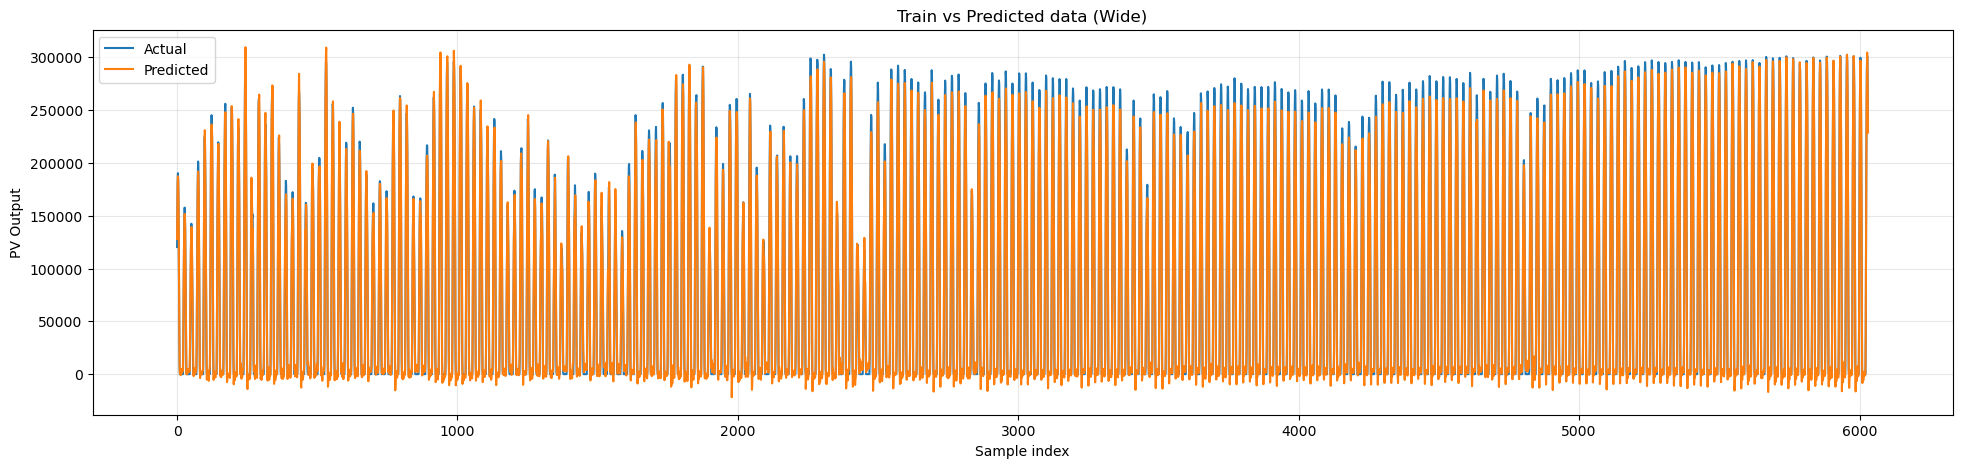

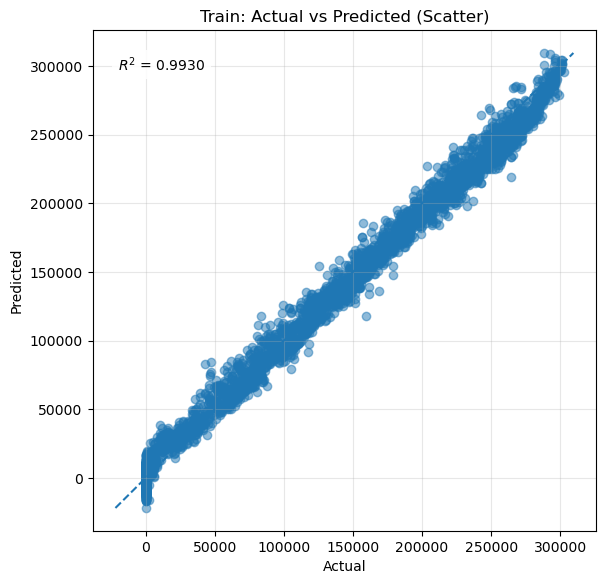

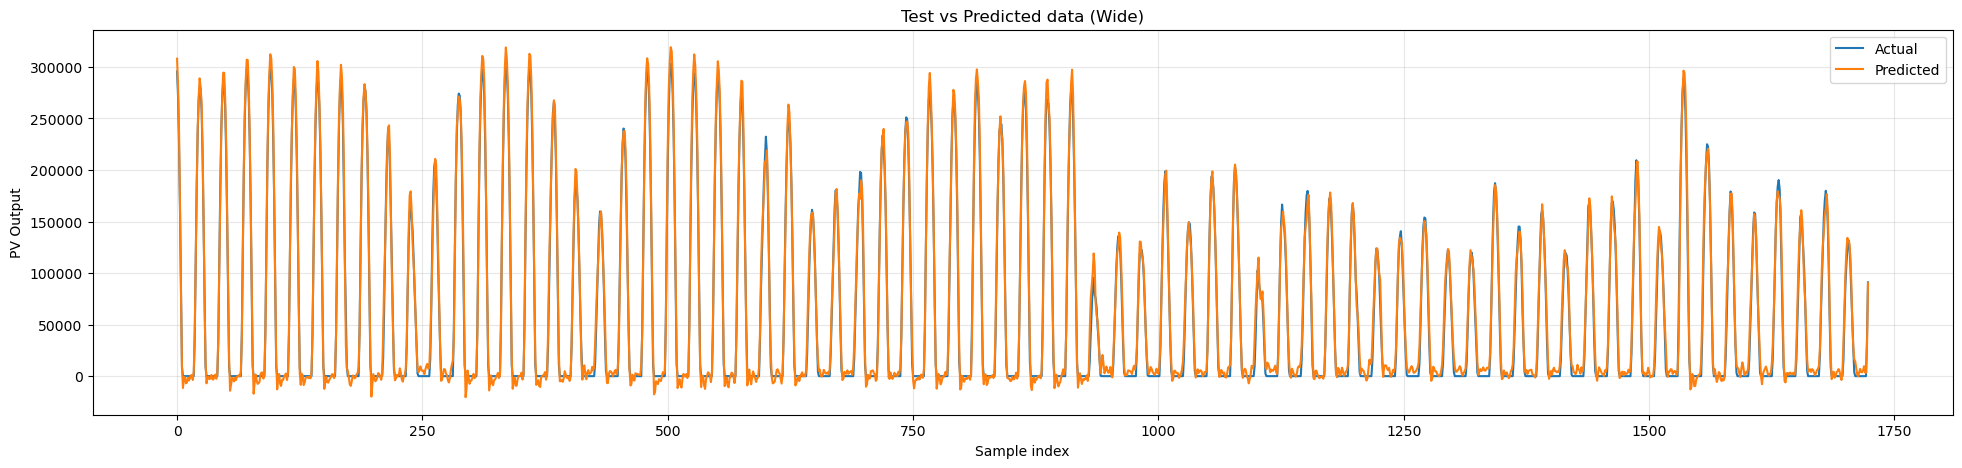

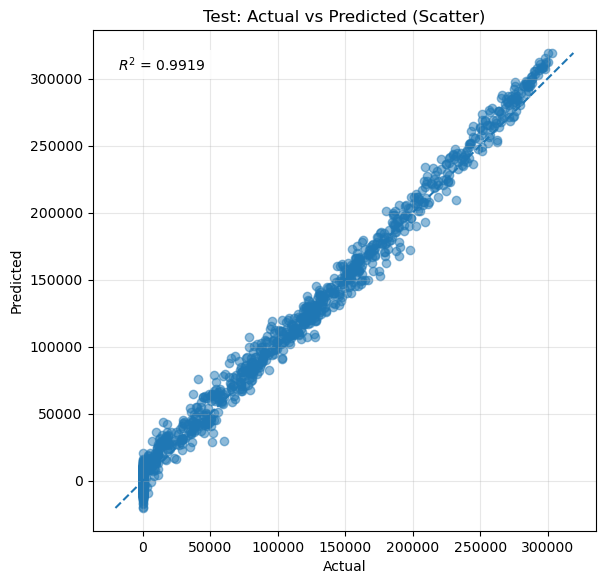

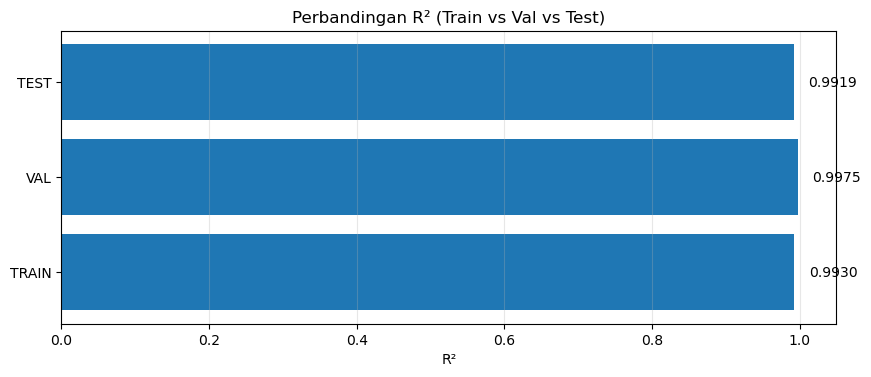

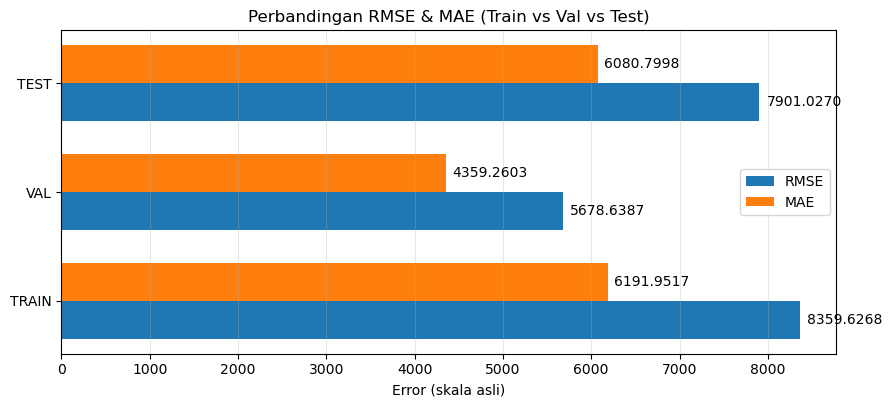

In [ ]:
# Plots
def maybe_subsample(y_true, y_pred, max_points=None):
    n = len(y_true)
    if (max_points is None) or (n <= max_points):
        x = np.arange(n)
        return x, y_true, y_pred
    idx = np.linspace(0, n-1, max_points).astype(int)
    x = np.arange(len(idx))
    return x, y_true[idx], y_pred[idx]

MAX_POINTS_LINE = 8000  # None untuk plot semua titik; turunkan kalau masih terlalu padat

# 1) TRAIN line plot (LEBAR)
x_tr, ytr, ytrp = maybe_subsample(y_train_inv, y_train_pred_inv, MAX_POINTS_LINE)
plt.figure(figsize=(24, 5))
plt.plot(x_tr, ytr,  label="Actual")
plt.plot(x_tr, ytrp, label="Predicted")
plt.title("Train vs Predicted data (Wide)")
plt.xlabel("Sample index")
plt.ylabel("PV Output")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# 2) TRAIN scatter + diagonal + R²
plt.figure(figsize=(6.5, 6.5))
plt.scatter(y_train_inv, y_train_pred_inv, alpha=0.5)

mn = min(np.min(y_train_inv), np.min(y_train_pred_inv))
mx = max(np.max(y_train_inv), np.max(y_train_pred_inv))

# diagonal line tanpa legend/label
plt.plot([mn, mx], [mn, mx], linestyle="--")

plt.title("Train: Actual vs Predicted (Scatter)")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.grid(alpha=0.3)

# teks R² (pake box biar kebaca)
plt.text(
    0.05, 0.95,
    f"$R^2$ = {r2_train:.4f}",
    transform=plt.gca().transAxes,
    va="top",
    bbox=dict(facecolor="white", alpha=0.85, edgecolor="none")
)

plt.show()

# 3) TEST line plot (LEBAR)
x_te, yte, ytep = maybe_subsample(y_test_inv, y_test_pred_inv, MAX_POINTS_LINE)
plt.figure(figsize=(24, 5))
plt.plot(x_te, yte,  label="Actual")
plt.plot(x_te, ytep, label="Predicted")
plt.title("Test vs Predicted data (Wide)")
plt.xlabel("Sample index")
plt.ylabel("PV Output")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# 4) TEST scatter + diagonal + R²
plt.figure(figsize=(6.5, 6.5))
plt.scatter(y_test_inv, y_test_pred_inv, alpha=0.5)

mn = min(np.min(y_test_inv), np.min(y_test_pred_inv))
mx = max(np.max(y_test_inv), np.max(y_test_pred_inv))

plt.plot([mn, mx], [mn, mx], linestyle="--")

plt.title("Test: Actual vs Predicted (Scatter)")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.grid(alpha=0.3)

plt.text(
    0.05, 0.95,
    f"$R^2$ = {r2_test:.4f}",
    transform=plt.gca().transAxes,
    va="top",
    bbox=dict(facecolor="white", alpha=0.85, edgecolor="none")
)

plt.show()

# Kumpulkan metrik
splits = ["TRAIN", "VAL", "TEST"]
rmse_vals = [rmse_train, rmse_val, rmse_test]
mae_vals  = [mae_train,  mae_val,  mae_test]
r2_vals   = [r2_train,   r2_val,   r2_test]

# --- FIG 1: R² (mirip contoh kamu, horizontal bar + label) ---
plt.figure(figsize=(10, 3.8))
ypos = np.arange(len(splits))

bars = plt.barh(ypos, r2_vals)
plt.yticks(ypos, splits)
plt.xlim(0, 1.05)
plt.xlabel("R²")
plt.title("Perbandingan R² (Train vs Val vs Test)")
plt.grid(axis="x", alpha=0.3)

# label angka
for i, v in enumerate(r2_vals):
    plt.text(min(v + 0.02, 1.02), i, f"{v:.4f}", va="center")

plt.show()

# --- FIG 2: RMSE & MAE (2 bar per split, horizontal bar + label) ---
plt.figure(figsize=(10, 4.2))
ypos = np.arange(len(splits))
h = 0.35

bars1 = plt.barh(ypos - h/2, rmse_vals, height=h, label="RMSE")
bars2 = plt.barh(ypos + h/2, mae_vals,  height=h, label="MAE")

plt.yticks(ypos, splits)
plt.xlabel("Error (skala asli)")
plt.title("Perbandingan RMSE & MAE (Train vs Val vs Test)")
plt.grid(axis="x", alpha=0.3)
plt.legend()

# label angka di ujung bar
for i, v in enumerate(rmse_vals):
    plt.text(v + (0.01 * max(rmse_vals)), i - h/2, f"{v:.4f}", va="center")
for i, v in enumerate(mae_vals):
    plt.text(v + (0.01 * max(mae_vals)),  i + h/2, f"{v:.4f}", va="center")

plt.show()

In [ ]:
# Save Predictions to CSV
df_results = pd.DataFrame({
    "time": time_test,
    "actual_pv": y_test_inv,
    "predicted_pv": y_test_pred_inv
})
df_results["error"] = df_results["predicted_pv"] - df_results["actual_pv"]

OUTPUT_CSV = "predictions_test.csv"
df_results.to_csv(OUTPUT_CSV, index=False)

print("Saved:", OUTPUT_CSV)
df_results.head(10)


Saved: predictions_test.csv


,time,actual_pv,predicted_pv,error
0,2024-10-21 04:00:00,295568.500000,307958.468750,12389.968750
1,2024-10-21 05:00:00,271418.406250,280591.750000,9173.343750
2,2024-10-21 06:00:00,225014.625000,236340.828125,11326.203125
3,2024-10-21 07:00:00,159466.828125,165359.828125,5893.000000
4,2024-10-21 08:00:00,79717.460938,80115.039062,397.578125
5,2024-10-21 09:00:00,8463.888672,8375.165039,-88.723633
6,2024-10-21 10:00:00,0.000000,-11509.127930,-11509.127930
7,2024-10-21 11:00:00,0.000000,-933.361755,-933.361755
8,2024-10-21 12:00:00,0.000000,-1122.638306,-1122.638306
9,2024-10-21 13:00:00,0.000000,-7025.938477,-7025.938477


: 